# Recommending Chess Openings

In this notebook we will explore what kinds of chess openings tend to go together. Suppose, for example, that a user like to use the Sicilian Defense. Are they more or less likely to also be users of the King''s Gambit?

The idea is that this should be an interesting application of recommendation.

In [1]:
import pandas as pd
games = pd.read_csv("../input/games.csv")
games.head(3)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3


## Exploring Feasibility

Before we go through with building a recommendation engine lets explore the feasibility of doing such a thing with the data that we have.

We will need to bring a couple of new fields into our frame. `opening_archetype` is the overall "type" of a opening that is used. Since chess openings have been studied for centuries, all of the relatively popular ones have many and many well-studied variations, information on which is included in `opening_name`. We don't need this additional information, so let's pull it out.

### Is the sample size large enough to build a model on?

In [2]:
games = (
    games.assign(
        opening_archetype=games.opening_name.map(
            lambda n: n.split(":")[0].split("|")[0].split("#")[0].strip()
        ),
        opening_moves=games.apply(lambda srs: srs['moves'].split(" ")[:srs['opening_ply']],
                                  axis=1)
    )
)

Now, if a player has only ever played a single game on the platform, then we do not learn anything about their opening preferences, because there is not enough data. Only players who have played `N>=2` games are helpful to us. How many such players are there?

4466 players who have played at least two games.


15635

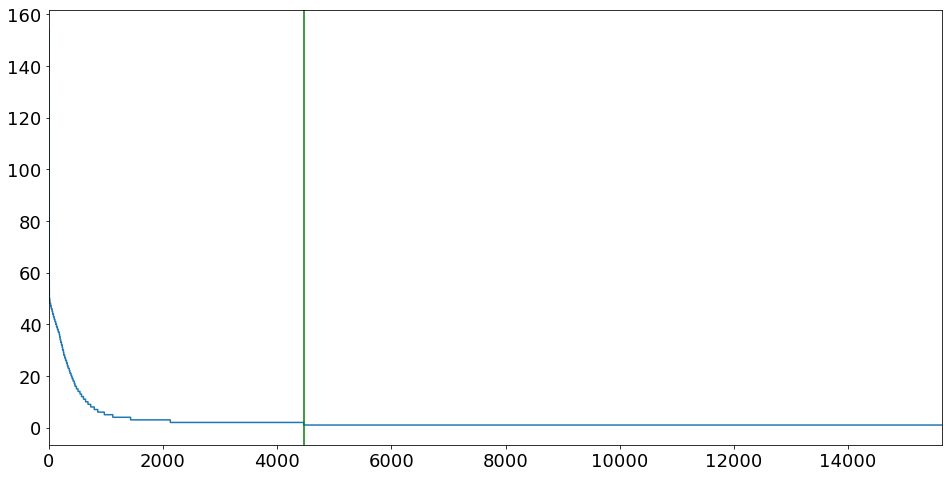

In [3]:
games_played = pd.concat([games['white_id'], games['black_id']]).value_counts()
games_played.reset_index(drop=True).plot.line(figsize=(16, 8), fontsize=18)

n_ge_2 = len(games_played[games_played > 1])
print(str(n_ge_2) + " players who have played at least two games.")

import matplotlib.pyplot as plt
plt.axvline(n_ge_2, color='green')

len(games_played)

How many games do those ~4500 players provide us with?

In [4]:
games_played[games_played > 1].sum()

28947

### Does strategy vary strongly enough amongst players?

We can think of our dataset as having ~4500 raters with ~30000 ratings amongst them. That seems like a decent enough sample size.

But what about the strength of player preferences? The more strongly our chess players tend to use the same opening moves&mdash;that is, the less preference they express, and the more standard the strategy they follow&mdash;the less interesting any recommendations will be.

So next, let's sense-check whether or there is significant playstyle variation between players. After doing some domain research, I decided to see what would happen if we pit players using the Sicilian Defense strategy (a standard *defensive* opening) against King's Gambit players (a standard *offensive* opening).

Because of how commonly played the Sicilian Defense is, I refer to the first of these distributions as the **Sicilian mean**, because it's reasonably close to the mean of all games played. The King's Gambit, meanwhile, is an also common, but significantly more "scipy" move.

Hopefully we will find that, in aggregate, players at least occassionally using these different strategies also use very different strategies overall.

In [5]:
opening_used = (pd.concat([
                   games.groupby('white_id')['opening_archetype'].value_counts(),
                   games.groupby('black_id')['opening_archetype'].value_counts()
                ])
                    .rename(index='openings_used')
                    .reset_index()
                    .rename(columns={'white_id': 'player_id', 'openings_used': 'times_used'})
                    .groupby(['player_id', 'opening_archetype']).sum()
               )

In [6]:
opening_used.head(10)

times_used
player_id           opening_archetype                 
--jim--             Scandinavian Defense             1
-0olo0-             French Defense                   1
-l-_jedi_knight_-l- Guatemala Defense                1
                    Hungarian Opening                3
                    King's Gambit Accepted           1
                    Owen Defense                     2
                    Pirc Defense                     1
                    Scandinavian Defense             4
-mati-              Barnes Defense                   1
-pavel-             Scandinavian Defense             1

In [7]:
(opening_used
     .reset_index()
     .groupby('player_id')
     .filter(lambda df: df.opening_archetype.isin(['Sicilian Defense']).any())
     .query('opening_archetype != "Sicilian Defense"')
     .groupby('opening_archetype')
     .times_used
     .sum()
     .sort_values(ascending=False)
     .to_frame()
     .pipe(lambda df: df.assign(times_used = df.times_used / df.times_used.sum()))
     .squeeze()
     .head(10)
)

opening_archetype
French Defense          0.081564
Italian Game            0.067175
Queen's Pawn Game       0.060557
Ruy Lopez               0.060095
King's Pawn Game        0.046322
Philidor Defense        0.043552
English Opening         0.042475
Scandinavian Defense    0.041474
Caro-Kann Defense       0.034857
Scotch Game             0.032779
Name: times_used, dtype: float64

In [8]:
(opening_used
     .reset_index()
     .groupby('player_id')
     .filter(lambda df: df.opening_archetype.isin(["King's Gambit"]).any())
     .query('opening_archetype != "King\'s Gambit"')
     .groupby('opening_archetype')
     .times_used
     .sum()
     .sort_values(ascending=False)
     .to_frame()
     .pipe(lambda df: df.assign(times_used = df.times_used / df.times_used.sum()))
     .squeeze()
     .head(10)
)

opening_archetype
Sicilian Defense        0.106635
French Defense          0.073460
King's Pawn Game        0.070300
Queen's Pawn Game       0.063981
Philidor Defense        0.063191
Italian Game            0.052923
Ruy Lopez               0.041864
Scandinavian Defense    0.039494
Four Knights Game       0.026856
Bishop's Opening        0.026066
Name: times_used, dtype: float64

There are many differences to take note of. A King's Pawn Game is about 50% more likely for a King's Gambit player than it is for a Sicilian mean player. Another difference is that the English Defense is much less popular with the latter. Other differences are also apparent.

Overall, there is decent evidence that recommendations built on chess openings would be useful. Overall, the variation in play that we found with this inspection seems significant.

## Building a Simple Recommendation Engine

Now that we've gathered evidence that doing so is useful, we move on to building our actual recommendation engine.

The simplest recommendation engine algorithm is **collaborative filtering**. In collaborative filtering, we can use one of two approaches to recommendation. Each one is an inverse of the other, and both are based on similarities between "stuff".

In the first approach, users are measured for the similarity between their ratings using some normalized distance metric. Then a new recommendation for a user is generated based on the weighed popularity of the items that similar users like.

### Converting Implicit Ratings to Explicit Ratings

Let's try this approach out. We already have users, but we haven't implemented ratings yet. Indeed, our dataset doesn't have so-called **explicit ratings**: our players don't "rate" chess openings on a five-star ranking system, for example. Instead, players are generating **implicit ratings**: they are choosing to use certain openings, or choosing not to use them, and those choices encode preferences, but not explicitly.

To proceed, we need to convert these implicit ratings to explicit ones. Since we're not building any serious system but merely demonstrating what is possible, let's use a simple exponential threshold approach. If a user has played `N` games, and used the opening in question more than `N / 4` times, then that opening is a five-star for them. More than `N / 8` is a four-star, more than `N / 16` is a three-star, and anything less than that is a two-star.

*Warning: this cells has not been vectorized and so takes about a minute-and-a-half to run.*

In [9]:
import numpy as np

def threshold_map(n_opening, n_all):
    if pd.isnull(n_opening):
        return np.nan
    elif n_opening / n_all >= 1 / 4:
        return 5
    elif n_opening / n_all >= 1 / 8:
        return 4
    elif n_opening / n_all > 1 / 16:
        return 3
    else:
        return 2

recommendations = opening_used.unstack(-1).loc[:, 'times_used'].apply(
    lambda srs: srs.map(lambda v: threshold_map(v, srs.sum())),
    axis='columns'
)

In [10]:
recommendations.head()

opening_archetype,Alekhine Defense,Amar Opening,Amazon Attack,Anderssen Opening,Australian Defense,Barnes Defense,Barnes Opening,Benko Gambit,Benko Gambit Accepted,Benko Gambit Declined,...,Trompowsky Attack,Valencia Opening,Van Geet Opening,Van't Kruijs Opening,Vienna Game,Wade Defense,Ware Defense,Ware Opening,Yusupov-Rubinstein System,Zukertort Opening
player_id,,,,,,,,,,,,,,,,,,,,,
--jim--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0olo0-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-l-_jedi_knight_-l-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-mati-,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-pavel-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This gets us a result which is relatively similar to what you find out "in the wild": a distribution dominated by 5-star ratings ([relevant XKCD](https://xkcd.com/1098/)).

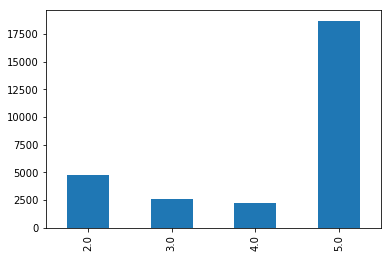

In [11]:
pd.Series(recommendations.values.flatten()).value_counts().sort_index().plot.bar()

### Choosing a Similarity Metric

To keep going, we need to know how to measure how similar two users are. One of the simplest metrics for measuring this is **cosine similarity**. To compare the similarity between two items (or users!) we do:

$$
s_u^{cos}(i_m,i_b)
 = \frac{ i_m \cdot i_b }{ \left \| i_m \right \| \left \| i_b \right \| }
 = \frac{ \sum x_{a,m} x_{a,b} }{ \sqrt{ \sum x_{a,m}^2 \sum x_{a,b}^2 } }
$$

The math is a bit intimidating, but the fundamental concept is relatively straightforward. Each of the possible items (openings) is a plane in N-dimensional space. High ratings contribute a lot of strength to the vector in that direction, low ratings contribute less, and null ratings contribute none at all. By taking the cosine of the angle formed between two of these crazy N-dimensional vectors, we get a "distance" that's between -1 and 1 (between 0 and 1 if the ratings are strictly positive).

### Executing the Model

`sklearn` comes with a built-in cosine similarity metric as a part of the `metrics.pairwise.pairwise_distances` function. We will use that to generate an item-item cosine similarity matrix.

In [12]:
from sklearn.metrics.pairwise import pairwise_distances
# user_similarity = pairwise_distances(train.fillna(0), metric='cosine')
item_similarity = pairwise_distances(recommendations.T.fillna(0), metric='cosine')

Now we have `item_similarity`, a big item-item similarity matrix that tells us how similar each of our 143 strategies is to every other strategy in our strategy set.

In [13]:
item_similarity.shape

(143, 143)

To generate predictions for our users, we take the **dot product** between this matrix and the user's rating matrix, and divide that by the sum of the similarity columns (to normalize). This nets us our predictions.

In [14]:
correction = np.array([np.abs(item_similarity).sum(axis=1)])
item_predictions = recommendations.fillna(0).dot(item_similarity).apply(
    lambda srs: srs / np.array([item_similarity.sum(axis=1)]).flatten(), axis='columns')

In [15]:
item_predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
player_id,,,,,,,,,,,,,,,,,,,,,
--jim--,0.034214,0.035298,0.034367,0.035092,0.035176,0.035199,0.034965,0.035221,0.035357,0.035315,...,0.034979,0.035052,0.034727,0.034081,0.033884,0.035128,0.035023,0.034451,0.035011,0.033724
-0olo0-,0.034111,0.035145,0.034739,0.035220,0.035228,0.035018,0.035152,0.034636,0.035042,0.035240,...,0.034861,0.034196,0.034326,0.032170,0.034502,0.034975,0.035269,0.034994,0.035148,0.034251
-l-_jedi_knight_-l-,0.160214,0.162370,0.159469,0.161316,0.161615,0.161384,0.161451,0.162302,0.161885,0.162258,...,0.161831,0.161429,0.161212,0.158373,0.159964,0.161762,0.161252,0.161136,0.161900,0.158805
-mati-,0.035660,0.035462,0.035368,0.035475,0.034205,0.000000,0.035295,0.035344,0.035357,0.035315,...,0.035256,0.035238,0.035173,0.034849,0.035723,0.035260,0.035139,0.035552,0.035399,0.034542
-pavel-,0.034214,0.035298,0.034367,0.035092,0.035176,0.035199,0.034965,0.035221,0.035357,0.035315,...,0.034979,0.035052,0.034727,0.034081,0.033884,0.035128,0.035023,0.034451,0.035011,0.033724


In [16]:
recommended_opening_numbers = item_predictions.apply(
    lambda srs: np.argmax(srs.values), axis='columns'
)
recommended_opening_numbers.head()

player_id
--jim--                 25
-0olo0-                129
-l-_jedi_knight_-l-     56
-mati-                 124
-pavel-                 25
dtype: int64

In [17]:
opening_names = pd.Series(recommendations.columns)
recommended_openings = recommended_opening_numbers.map(opening_names)

Which finally nets us our recommended openings!

In [18]:
recommended_openings.head()

player_id
--jim--                Center Game Accepted
-0olo0-                              System
-l-_jedi_knight_-l-    Hippopotamus Defense
-mati-                     Sicilian Defense
-pavel-                Center Game Accepted
dtype: object

### User Outcomes

What openings does our simple classifier recommend most often?

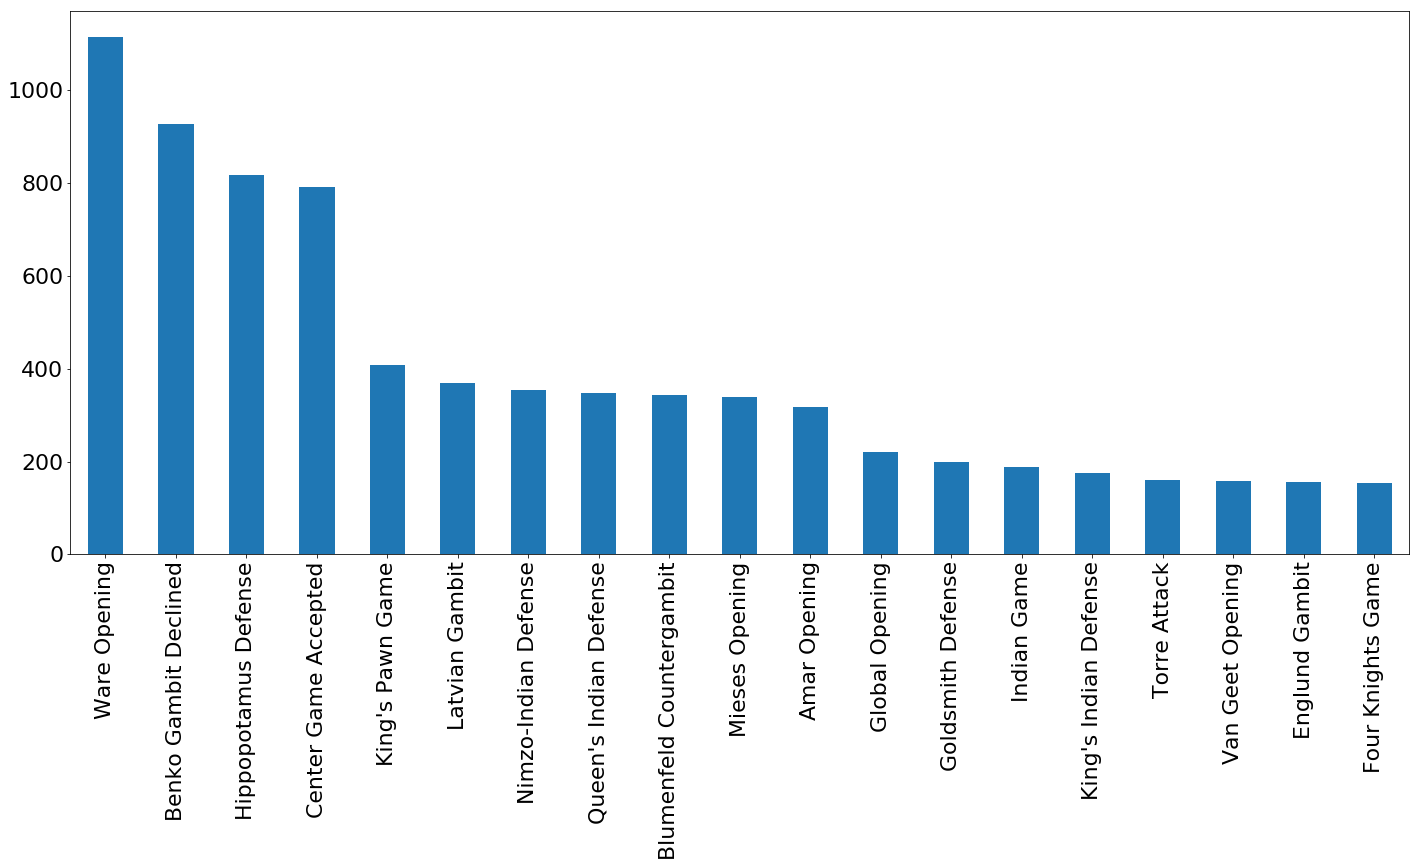

In [19]:
recommended_openings.value_counts().head(20).iloc[1:].plot.bar(figsize=(24, 10), fontsize=22)

It's important to note here that we are excluding `System`, which seems to function as more or less a default option. A chess system is an opening strategy where a player follows a set methodology for developing their pieces irrespective of what their opponent does. This doesn't strike me as being a very interesting recommendation, so I've excluded it from the results.

Note that we can also take the second-best recommendation and use that instead in those cases.

## Conclusions

This notebook demonstrated building a simple implicit ratings collaborative filtering recommendation engine. While the little engine we built isn't terrifically good, it does demonstrate the key concepts behind building a neat little tool.

Perhaps now you should try building an off-the-shelp recommendation engine using the [`surprise`](http://surprise.readthedocs.io/en/stable/getting_started.html#getting-started) package ([link](http://surprise.readthedocs.io/en/stable/getting_started.html#getting-started)), also available here on Kaggle!

## Further Reading

**Collaborative Filtering**
* http://www.salemmarafi.com/code/collaborative-filtering-with-python/
* http://tungwaiyip.info/2012/Collaborative%20Filtering.html
* http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
* https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html#model-based-collaborative-filtering

**Similar Notebooks**
* https://www.kaggle.com/philippsp/book-recommender-collaborative-filtering-shiny &mdash; product focused, in R
